In [1]:
import os
from pandas import concat, Series, DataFrame, options
from numpy import inf
import matplotlib.pyplot as plt

from project.model import get_inputs
from project.utils import cumulated_plot, cumulated_plots

In [2]:
path = 'output/static'
if not os.path.isdir(path):
    os.mkdir(path)

In [3]:
insulation = {'Wall': (True, False, False, False), 'Floor': (False, True, False, False), 'Roof': (False, False, True, False), 'Windows': (False, False, False, True), 'Global': (True, True, True, True)}

### Loading inputs

In [4]:
output = get_inputs(path)

2022-09-30 15:29:16,390 - 24800 - log_static - INFO - Creating AgentBuildings object


In [5]:
buildings = output['buildings']
energy_prices = output['energy_prices']
cost_insulation = output['cost_insulation']
carbon_emission = output['carbon_emission']
carbon_value_kwh = output['carbon_value_kwh']

## Calculating potential
1. Initial consumption of the building stock
2. Potential energy reduction after insulation measures
3. Cost of insulation measures
4. Cost-efficiency of potential measures
5. Marginal Abatement Cost (MAC) curve

In [6]:
output = buildings.mitigation_potential(energy_prices, cost_insulation, carbon_emission, carbon_value_kwh)

In [7]:
output.keys()

dict_keys(['Stock (dwellings)', 'Consumption before (kWh/dwelling)', 'Consumption before (kWh/segment)', 'Consumption actual before (kWh/dwelling)', 'Consumption actual before (kWh/segment)', 'Consumption actual after (kWh/dwelling)', 'Consumption actual after (kWh/segment)', 'Consumption saved (kWh/dwelling)', 'Consumption saved (kWh/segment)', 'Consumption actual saved (kWh/dwelling)', 'Consumption actual saved (kWh/segment)', 'Emission before (gCO2/dwelling)', 'Emission after (gCO2/dwelling)', 'Emission saved (gCO2/dwelling)', 'Emission value before (euro/dwelling)', 'Emission value after (euro/dwelling)', 'Emission value saved (euro/dwelling)', 'Cost insulation (euro/dwelling)', 'Cost insulation (euro/segment)', 'Bill before (euro/dwelling)', 'Bill after (euro/dwelling)', 'Bill saved (euro/dwelling)'])

### Actual consumption of the building stock

In [8]:
total_surface = (buildings.surface * buildings.stock).sum()
print('{:,.0f} Million m2'.format(total_surface / 10**6))

2,263 Million m2


In [9]:
consumption_total_before = output['Consumption actual before (kWh/segment)'].sum()
print('{:,.0f} TWh'.format(consumption_total_before / 10**9))

consumption_standard_before = output['Consumption before (kWh/segment)'].sum()
print('{:,.0f} TWh'.format(consumption_standard_before / 10**9))

234 TWh
338 TWh


##### Distribution insulation

In [10]:
temp = dict()
for i in ['Wall', 'Floor', 'Roof', 'Windows']:
    y = Series(buildings.stock.index.get_level_values(i), index=buildings.stock.index, name='{} insulation (W/m2.K)'.format(i)).astype('float')
    x = buildings.stock / 10**6
    temp.update({i: cumulated_plot(x, y, plot=False)})


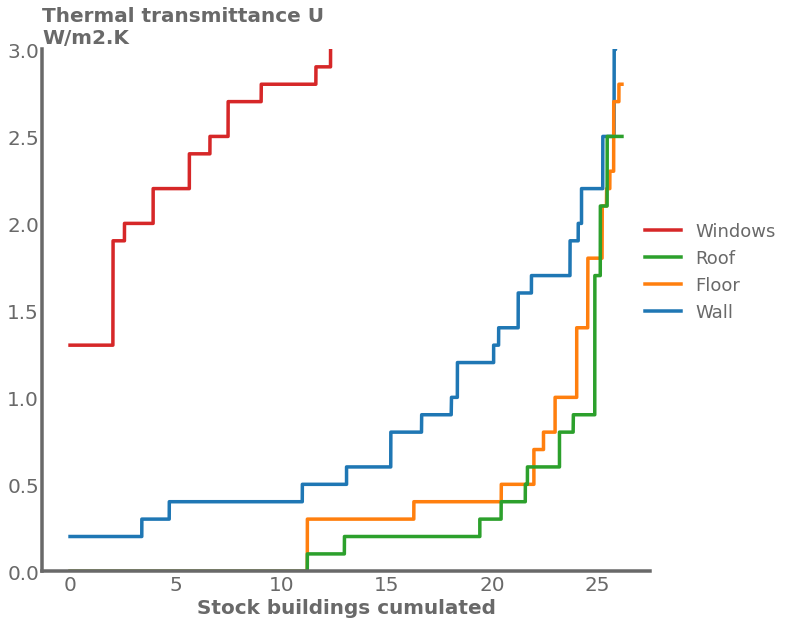

In [11]:
cumulated_plots(temp, 'Thermal transmittance U (W/m2.K)', ylim=3)


##### kWh/m2 distribution by building

In [12]:
print(output['Consumption actual before (kWh/segment)'].sum() / total_surface)

103.38003823055537


In [13]:
(output['Consumption actual before (kWh/dwelling)'] / buildings.surface).describe()

count    9720.000000
mean      142.694821
std        73.426451
min        10.483519
25%        89.128992
50%       132.764528
75%       188.951246
max       464.445617
dtype: float64

##### kWh/building distribution

count     9720.000000
mean     11413.793317
std       6413.162606
min        598.711227
25%       6357.366932
50%      10269.719646
75%      15796.531419
max      37649.856234
dtype: float64


<AxesSubplot:>

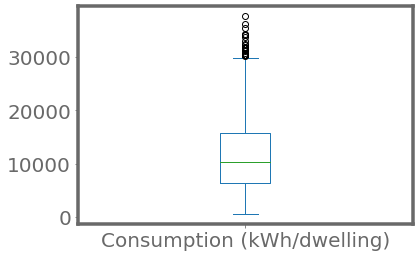

In [14]:
print(output['Consumption actual before (kWh/dwelling)'].describe())
output['Consumption actual before (kWh/dwelling)'].rename('Consumption (kWh/dwelling)').plot.box()

### Potential energy consumption saved by insulation measures

#### Final energy consumption after insulation

In [15]:
consumption_total_after = output['Consumption actual after (kWh/segment)'].sum()
concat((consumption_total_after / 10**9, consumption_total_after / total_surface), keys=['Consumption (TWh)', 'Consumption (kWh/m2)'], axis=1)

Consumption (TWh)  Consumption (kWh/m2)
Wall  Floor Roof  Windows                                         
False False False True            203.272377             89.807100
            True  False           216.283347             95.555434
                  True            184.261522             81.407977
      True  False False           220.820003             97.559759
                  True            188.856567             83.438099
            True  False           201.675110             89.101417
                  True            168.076650             74.257392
True  False False False           179.425782             79.271515
                  True            142.916036             63.141264
            True  False           158.989666             70.242701
                  True            120.687477             53.320537
      True  False False           164.536280             72.693233
                  True            126.338326             55.817120
            True  False           142.237473             62.841470
                  True            101.782271             44.968090

#### Energy saving

In [16]:
# Global mitigation potential
consumption_total_saved = output['Consumption actual saved (kWh/segment)'].sum().loc[insulation.values()]
concat((consumption_total_saved / 10**9, consumption_total_saved / total_surface, consumption_total_saved / consumption_total_before), keys=['Consumption saved (TWh/year)', 'Consumption saved (kWh/m2)', 'Percentage saved (%)'], axis=1)

Consumption saved (TWh/year)  \
Wall  Floor Roof  Windows                                 
True  False False False                       54.568034   
False True  False False                       13.173813   
      False True  False                       17.710469   
            False True                        30.721439   
True  True  True  True                       132.211545   

                           Consumption saved (kWh/m2)  Percentage saved (%)  
Wall  Floor Roof  Windows                                                    
True  False False False                     24.108524              0.233203  
False True  False False                      5.820279              0.056300  
      False True  False                      7.824604              0.075688  
            False True                      13.572938              0.131292  
True  True  True  True                      58.411948              0.565022

Roof and floor seems to contribute less than expected.  They are only targeted single-family dwelling.

In [17]:
output['Consumption actual saved (kWh/dwelling)'].loc[:, insulation.values()].describe()

Wall             True         False                                      True
Floor           False          True         False                        True
Roof            False         False          True         False          True
Windows         False         False         False          True          True
count     9720.000000   9720.000000   9720.000000   9720.000000   9720.000000
mean      2261.382978   1308.999355   1165.865486   1493.387991   7362.192471
std       2474.637347   2042.403182   1980.641881   1823.348940   5416.018166
min          0.000000      0.000000      0.000000      0.000000      0.000000
25%        331.673165      0.000000      0.000000    565.393609   3126.257121
50%       1180.123308    259.071462    330.770581   1014.294951   6097.689535
75%       3499.355859   2220.218783   1044.913068   1654.620928  11092.111289
max      15621.887191  12392.599237  12319.632585  15335.089312  29296.768674

### Cost of measures

In [18]:
output['Cost insulation (euro/dwelling)'].loc[:, insulation.values()].describe()

Wall             True        False                                    True
Floor           False         True        False                       True
Roof            False        False         True        False          True
Windows         False        False        False         True          True
count     9720.000000  9720.000000  9720.000000  9720.000000   9720.000000
mean     12092.638354  2510.196142  4193.132675  5058.903095  23854.870265
std       2731.270843  1597.836859  2669.091004   540.552023   7352.344465
min       7704.000000     0.000000     0.000000  4349.550000  12053.550000
25%       9115.200000     0.000000     0.000000  4638.436000  14261.490000
50%      13517.920000  3462.225000  5783.440000  5192.902000  27956.487000
75%      13517.920000  3462.225000  5783.440000  5192.902000  27956.487000
max      16994.400000  4352.625000  7270.800000  6528.390000  35146.215000

In [19]:
cost = (output['Cost insulation (euro/dwelling)'].T / buildings.surface).T
cost.loc[:, insulation.values()].describe()

Wall            True        False                                   True
Floor          False         True        False                      True
Roof           False        False         True        False         True
Windows        False        False        False         True         True
count    9720.000000  9720.000000  9720.000000  9720.000000  9720.000000
mean      152.019753    28.462963    47.545679    65.776049   293.804444
std         5.050487    17.924720    29.942173     9.776300    43.141080
min       144.000000     0.000000     0.000000    59.620000   225.300000
25%       144.000000     0.000000     0.000000    59.620000   225.300000
50%       155.200000    39.750000    66.400000    59.620000   320.970000
75%       155.200000    39.750000    66.400000    81.300000   320.970000
max       155.200000    39.750000    66.400000    81.300000   320.970000

### Cost-efficiency of renovation measures

In [20]:
discount_rate = 0.04
discount_factor = (1 - (1 + discount_rate) ** -30) / discount_rate
print(discount_factor)

17.29203330066449


In [21]:
consumption_saved = output['Consumption saved (kWh/segment)']
cost_efficiency = output['Cost insulation (euro/dwelling)'] / (output['Consumption saved (kWh/dwelling)'] * discount_factor)
cost_efficiency.replace([inf, -inf], 0, inplace=True)
cost_efficiency.fillna(0, inplace=True)

In [22]:
temp, temp_percent, temp_stock = dict(), dict(), dict()
for key, item in insulation.items():
    x = consumption_saved.loc[:, item].rename('Consumption saved (TWh)') / 10**9
    x_percent = (consumption_saved.loc[:, item] / consumption_standard_before).rename('Consumption saved (%)')
    x_stock = buildings.stock / 10**6

    y = cost_efficiency.loc[:, item].rename('{} insulation'.format(key))

    temp.update({key: cumulated_plot(x, y, plot=False)})
    temp_percent.update({key: cumulated_plot(x_percent, y, plot=False)})
    temp_stock.update({key: cumulated_plot(x_stock, y, plot=False)})

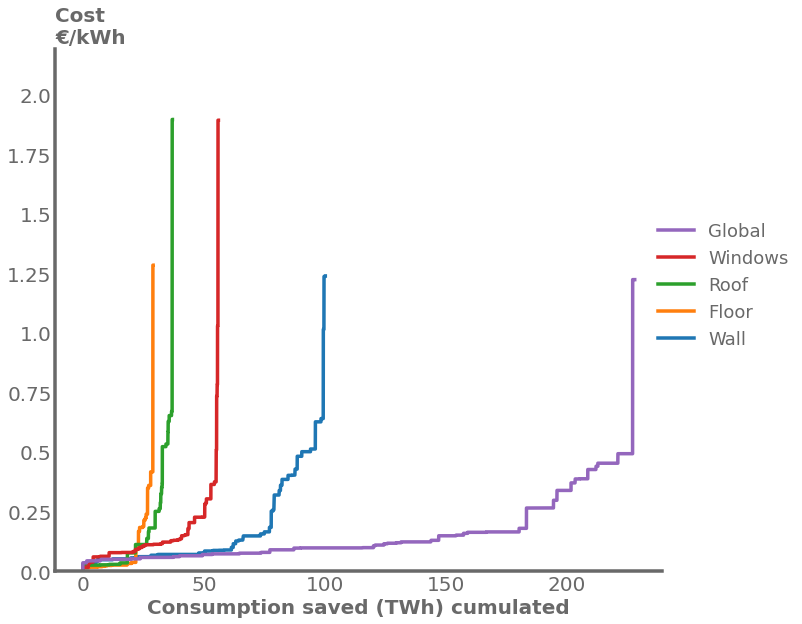

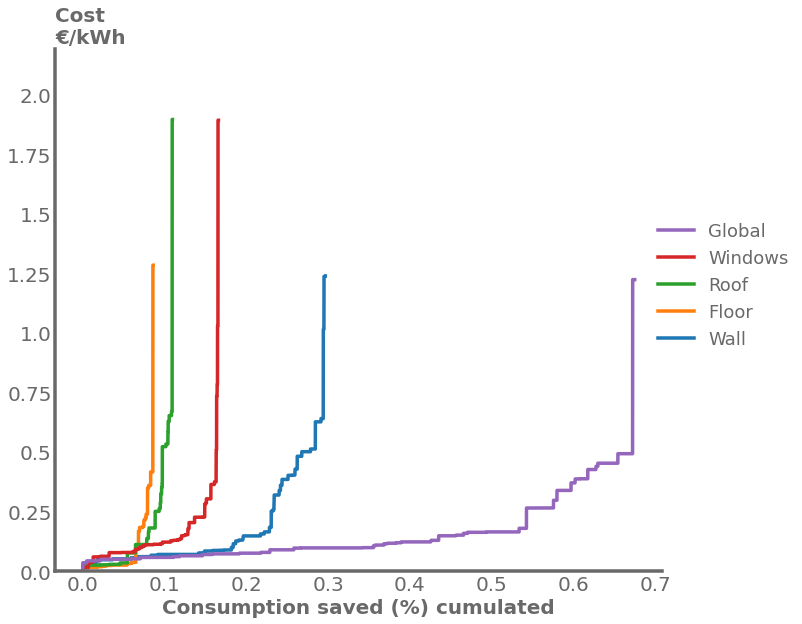

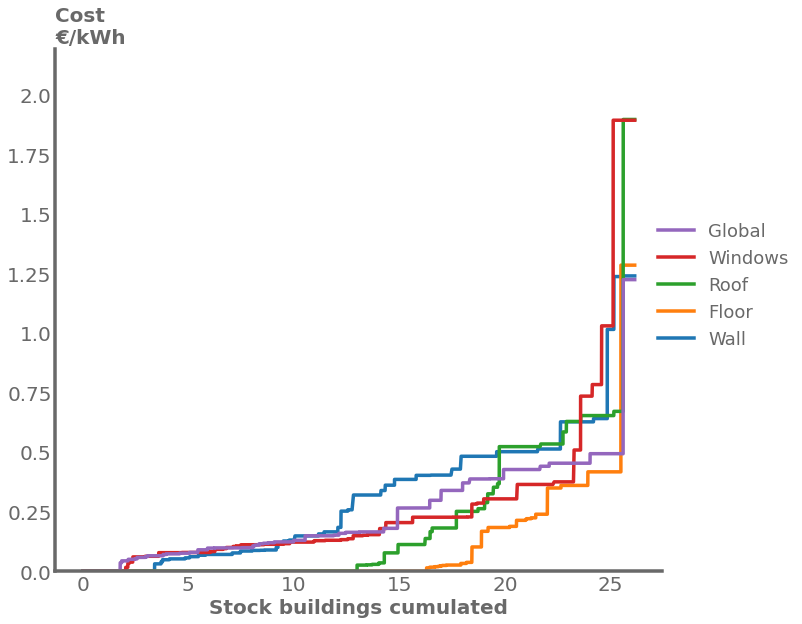

In [23]:
cumulated_plots(temp, 'Cost (€/kWh)')
cumulated_plots(temp_percent, 'Cost (€/kWh)')
cumulated_plots(temp_stock, 'Cost (€/kWh)')

### Net present value assessment

In [24]:
output.keys()

dict_keys(['Stock (dwellings)', 'Consumption before (kWh/dwelling)', 'Consumption before (kWh/segment)', 'Consumption actual before (kWh/dwelling)', 'Consumption actual before (kWh/segment)', 'Consumption actual after (kWh/dwelling)', 'Consumption actual after (kWh/segment)', 'Consumption saved (kWh/dwelling)', 'Consumption saved (kWh/segment)', 'Consumption actual saved (kWh/dwelling)', 'Consumption actual saved (kWh/segment)', 'Emission before (gCO2/dwelling)', 'Emission after (gCO2/dwelling)', 'Emission saved (gCO2/dwelling)', 'Emission value before (euro/dwelling)', 'Emission value after (euro/dwelling)', 'Emission value saved (euro/dwelling)', 'Cost insulation (euro/dwelling)', 'Cost insulation (euro/segment)', 'Bill before (euro/dwelling)', 'Bill after (euro/dwelling)', 'Bill saved (euro/dwelling)'])

In [25]:
discount_rate = 0.08
discount_factor = (1 - (1 + discount_rate) ** -30) / discount_rate
print(discount_factor)

11.257783343127485


In [26]:
npv = output['Cost insulation (euro/dwelling)'] - output['Bill saved (euro/dwelling)'] * discount_factor

In [27]:
i = 'Floor'
details = concat((output['Cost insulation (euro/dwelling)'].loc[:, insulation[i]], output['Bill saved (euro/dwelling)'].loc[:, insulation[i]] * discount_factor, npv.loc[:, insulation[i]].rename('NPV (euro/dwelling)')), axis=1).sort_values('NPV (euro/dwelling)')

In [28]:
temp, temp_percent, temp_stock = dict(), dict(), dict()
for key, item in insulation.items():
    x = consumption_saved.loc[:, item].rename('Consumption saved (TWh)') / 10**9
    x_percent = (consumption_saved.loc[:, item] / consumption_standard_before).rename('Consumption saved (%)')
    x_stock = buildings.stock / 10**6

    y = npv.loc[:, item].rename('{} insulation'.format(key)) / 10**3

    temp.update({key: cumulated_plot(x, y, plot=False)})
    temp_percent.update({key: cumulated_plot(x_percent, y, plot=False)})
    temp_stock.update({key: cumulated_plot(x_stock, y, plot=False)})

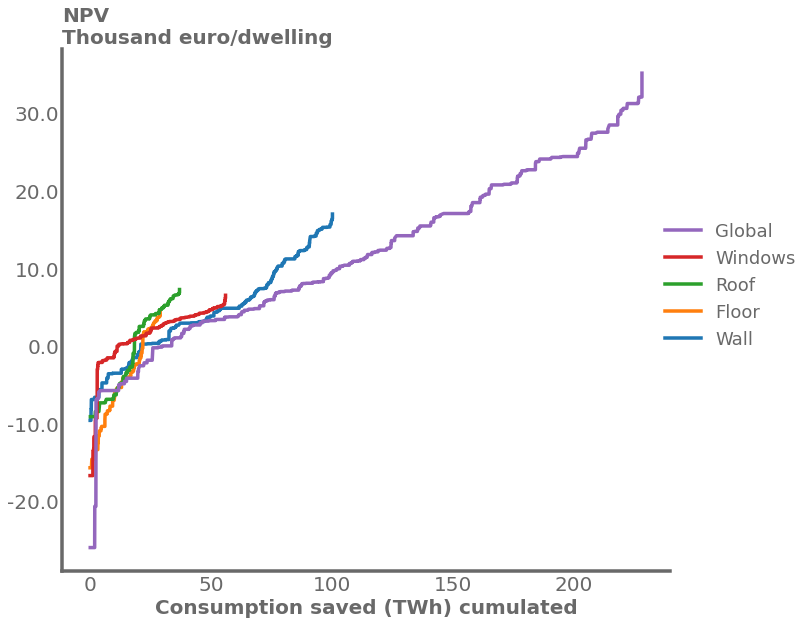

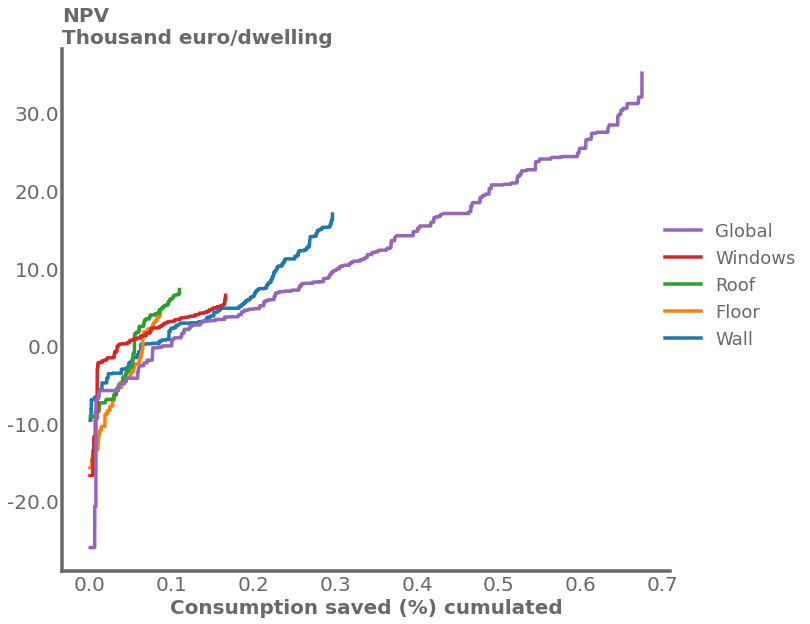

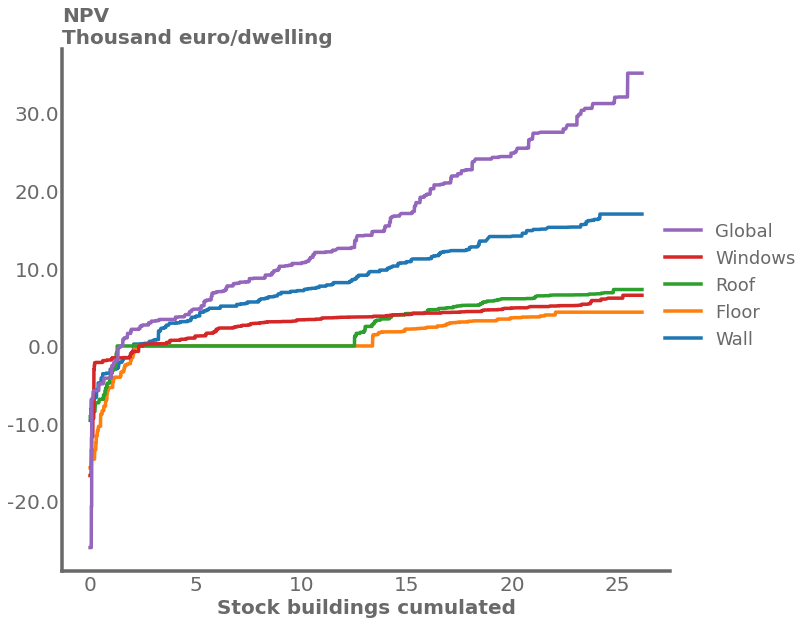

In [29]:
cumulated_plots(temp, 'NPV (Thousand euro/dwelling)', ymin=None)
cumulated_plots(temp_percent, 'NPV (Thousand euro/dwelling)', ymin=None)
cumulated_plots(temp_stock, 'NPV (Thousand euro/dwelling)', ymin=None)

#### Social assessment

In [30]:
social_npv = output['Cost insulation (euro/dwelling)'] - (output['Bill saved (euro/dwelling)'] + output['Emission value saved (euro/dwelling)']) * discount_factor

In [31]:
temp, temp_percent, temp_stock = dict(), dict(), dict()
for key, item in insulation.items():
    x = consumption_saved.loc[:, item].rename('Consumption saved (TWh)') / 10**9
    x_percent = (consumption_saved.loc[:, item] / consumption_standard_before).rename('Consumption saved (%)')
    x_stock = buildings.stock / 10**6

    y = social_npv.loc[:, item].rename('{} insulation'.format(key)) / 10**3

    temp.update({key: cumulated_plot(x, y, plot=False)})
    temp_percent.update({key: cumulated_plot(x_percent, y, plot=False)})
    temp_stock.update({key: cumulated_plot(x_stock, y, plot=False)})

ValueError: Length of names must match number of levels in MultiIndex.

In [ ]:
cumulated_plots(temp, 'NPV (Thousand euro/dwelling)', ymin=None)
cumulated_plots(temp_percent, 'NPV (Thousand euro/dwelling)', ymin=None)
cumulated_plots(temp_stock, 'NPV (Thousand euro/dwelling)', ymin=None)

### Marginal Energy Saving Cost Curves (MESC-Curves)
These curves show for each amount of energy demand savings (x-axis) the costs of the last renovation action to be taken to reach these savings (y-axis).

### Energy Saving Cost Curves (ESC-Curves)
These curves show for each amount of energy demand savings (x-axis) the average costs of all renovation actions to be implemented to reach these savings (y-axis).